# Case Studies -- Data Engineering

## Setting
This notebook presents a simple example of monitoring a model's performance over time.

The data represents the runs' duration of a bus on a given route.
The data is synthetic, but it is typical for public transportation operators.
The data is already curated and contains only a few possible features that we could find in real data.
However, it is sufficient to produce a simple model and follow its accuracy over time.

The data includes the following variables:
- start_at (datetime): the timestamp of the start of the run in iso-format
- date (datetime): the date of start_at
- run (int): identifier for the run, unique for the given service (daily).
- time (int): start_at time in seconds since the start of the day.
- hour (int): start_at hour.
- minute (int): start_at minute.
- second (int): start_at second.
- weekday (int): date's weekday number (0 for Monday).
- duration (float): bus' travel time for that run.

The data covers a period of February to June 2019.

## Importing Data

In [ ]:
!pip install river
# Put all imports at the top of the code.
# This way, dependencies are easier to find.
import pandas
import river.drift
import seaborn

from sklearn.ensemble import RandomForestRegressor

In [ ]:
data = pandas.read_csv("data.csv.gz", parse_dates=["start_at", "date"])
data.head()

,start_at,date,run,time,hour,minute,second,weekday,duration
0,2019-02-01 05:00:02,2019-02-01,0,18002,5,0,2,4,36.033333
1,2019-02-01 05:20:55,2019-02-01,1,19255,5,20,55,4,43.316667
2,2019-02-01 05:39:19,2019-02-01,2,20359,5,39,19,4,34.416667
3,2019-02-01 05:57:22,2019-02-01,3,21442,5,57,22,4,44.300000
4,2019-02-01 06:16:43,2019-02-01,4,22603,6,16,43,4,42.100000


<Axes: xlabel='time', ylabel='duration'>

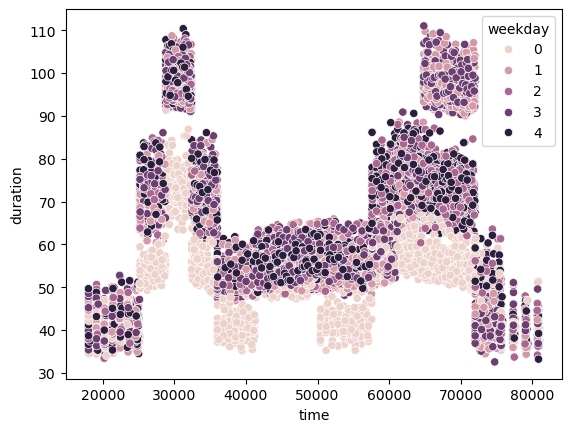

In [ ]:
seaborn.scatterplot(data, x="time", y="duration", hue="weekday")

### Questions
1. Do you see anything special about date coverage ?
2. From the scatterplot, can you notice whether or not there is a changepoint in the data ? What is it best at showing us ?
3. Propose another plot that would be more suitable for showing changepoints.

### 1

It is interesting to check the continuity of the dataset, considering that it it include temporal observation. So, it is necessary to check if there are missing dates.

In [ ]:
# Check the date range and unique dates in the dataset
date_range = data["date"].agg(["min", "max"])  # Get the min and max dates in the dataset
unique_dates = data["date"].nunique()  # Count the number of unique dates

# Output the date range and number of unique dates
print("Date Range:", date_range)
print("Number of Unique Dates:", unique_dates)

# Verify if there are missing dates
from pandas import date_range as pd_date_range

# Generate the expected date range from the min and max date
expected_dates = pd_date_range(start=date_range["min"], end=date_range["max"])

# Identify missing dates (those in the expected range but not in the data)
missing_dates = set(expected_dates) - set(data["date"].unique())

# Output whether there are missing dates
if not missing_dates:
    print("\nThere are no missing dates in the dataset, it is continuous!")
else:
    print("\nMissing Dates:")
    print(missing_dates)  # List the missing dates

# Answering the question
if missing_dates:
    print("\nConsideration about data coverage: The dataset does not have data for some days within the expected date range. Therefore, it is discontinuous.")
else:
    print("\nConsideration about data coverage: The dataset is continuous with no missing dates.")


Date Range: min   2019-02-01
max   2019-05-31
Name: date, dtype: datetime64[ns]
Number of Unique Dates: 86

Missing Dates:
{Timestamp('2019-03-24 00:00:00'), Timestamp('2019-03-16 00:00:00'), Timestamp('2019-03-09 00:00:00'), Timestamp('2019-03-02 00:00:00'), Timestamp('2019-04-28 00:00:00'), Timestamp('2019-04-13 00:00:00'), Timestamp('2019-05-18 00:00:00'), Timestamp('2019-04-27 00:00:00'), Timestamp('2019-04-07 00:00:00'), Timestamp('2019-03-10 00:00:00'), Timestamp('2019-04-06 00:00:00'), Timestamp('2019-02-23 00:00:00'), Timestamp('2019-02-03 00:00:00'), Timestamp('2019-02-02 00:00:00'), Timestamp('2019-04-20 00:00:00'), Timestamp('2019-05-12 00:00:00'), Timestamp('2019-03-30 00:00:00'), Timestamp('2019-04-21 00:00:00'), Timestamp('2019-05-11 00:00:00'), Timestamp('2019-04-14 00:00:00'), Timestamp('2019-03-31 00:00:00'), Timestamp('2019-03-23 00:00:00'), Timestamp('2019-02-09 00:00:00'), Timestamp('2019-05-26 00:00:00'), Timestamp('2019-03-17 00:00:00'), Timestamp('2019-05-05 00:0

### 2

The scatter plot does not clearly indicate a changepoint. Actually it is not very effective for what it concerns the observation of the mean or variance shift.

### 3

To show changepoints, it is better to create a plot that inspects how duration evolves over time, displaying duration on the y-axis and date on the x-axis.

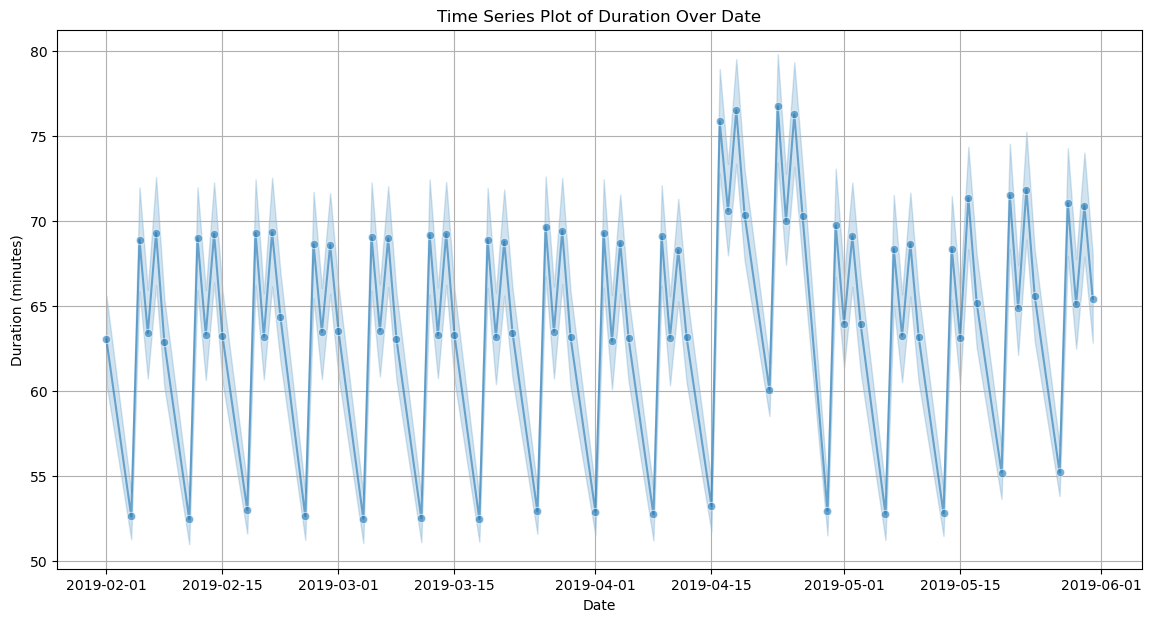

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create a time series plot of duration over date.
plt.figure(figsize=(14, 7))
sns.lineplot(data=data, x="date", y="duration", marker="o", alpha=0.6)
plt.title("Time Series Plot of Duration Over Date")
plt.xlabel("Date")
plt.ylabel("Duration (minutes)")
plt.grid(True)
plt.show()

Where the trend changes abruptly, it is an indication of a potential changepoint. These abrupt shifts in the pattern of duration suggest that something significant may have happened in the process.

## Modeling
In this section, we will build a simple regressor for duration.

We will train the model on February and then test the model at the beginning of April and at the beginning of June.

### Splitting Data
In order to do so, we will work with boolean indexing for rows. This way, we keep the length of our filters as the initial length of the data. We can then work with usual boolean operations to compose filters. This is easier to deal with than multiple data subsets. Alternatively, we could have set start_at as an index and work with datetime indexing.

In [ ]:
train = data.start_at < "2019-03-01"
validation = (data.start_at < "2019-04-01") & ~train
test = ~train & ~validation
Ycol = "duration"
Xcols = data.columns.difference([Ycol, "start_at", "date"])

In [ ]:
# Split the data into features and target for training
X_train = data.loc[train, Xcols]
y_train = data.loc[train, Ycol]

# Similarly for validation and test sets
X_validation = data.loc[validation, Xcols]
y_validation = data.loc[validation, Ycol]

X_test = data.loc[test, Xcols]
y_test = data.loc[test, Ycol]

### Learning
Now create your favourite quick model for duration and fit the model on training data

In [ ]:
seed = 42
X_train = data.loc[train, Xcols]
y_train = data.loc[train, Ycol]

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Set the random seed for reproducibility
seed = 42

# Initialize the RandomForestRegressor with the seed for reproducibility
mdl = RandomForestRegressor(random_state=seed)

# Fit the model on the training data
mdl.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### Testing
Compute and compare MAE on validation and testing datasets

In [ ]:
X_val = data.loc[validation, Xcols]
y_val = data.loc[validation, Ycol]

# Predict the target (duration) on the validation and test sets
y_pred_val = mdl.predict(X_validation)
y_pred_test = mdl.predict(X_test)

# Calculate Mean Absolute Error (MAE) for both validation and test sets
mae_val = mean_absolute_error(y_validation, y_pred_val)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Print out the results
print(f"Validation MAE: {mae_val:.2f}")
print(f"Test MAE: {mae_test:.2f}")

Validation MAE: 2.48
Test MAE: 3.55


What can we conclude about model's performance ?

MAE is quite low. This means that the model makes accurate predictions.

### Visualisation of Historical Changepoints
 Do simulate this, we will work with the models errors series.

- Plot the errors.

How many changepoints can you visually see in the data ?

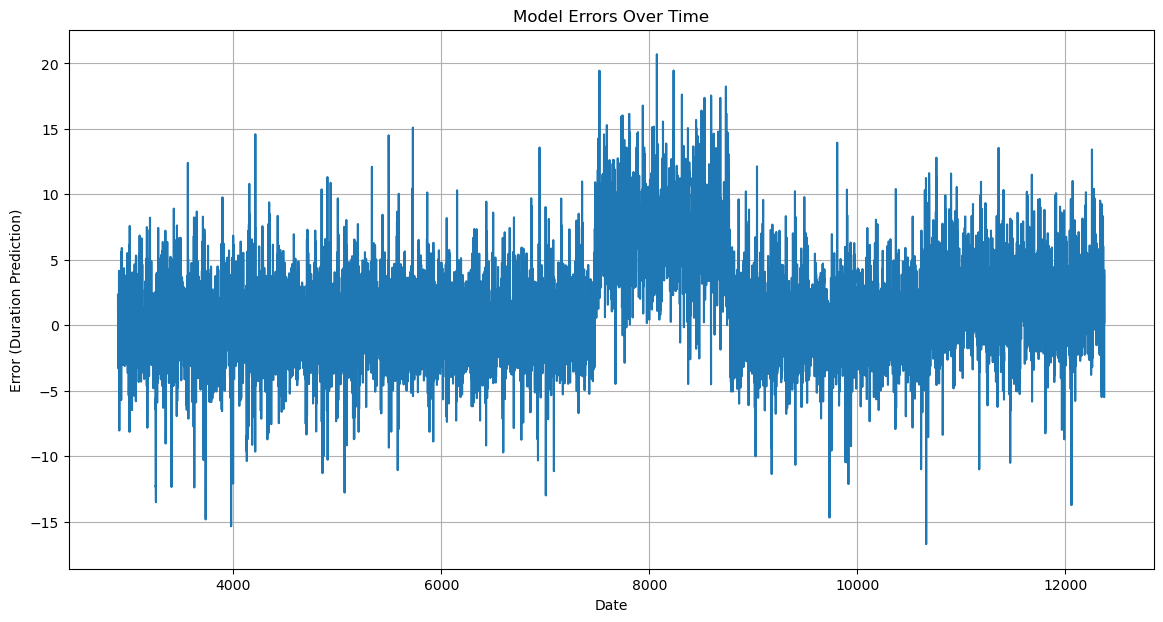

In [ ]:
import pandas as pd

# Calculate errors (residuals) for validation and test datasets
errors_val = y_validation - y_pred_val
errors_test = y_test - y_pred_test

# Combine errors for plotting using pd.concat
errors = pd.concat([errors_val, errors_test])

# Plot errors (residuals)
plt.figure(figsize=(14, 7))
sns.lineplot(x=errors.index, y=errors)
plt.title("Model Errors Over Time")
plt.xlabel("Date")
plt.ylabel("Error (Duration Prediction)")
plt.grid(True)
plt.show()

Two changepoints are visually identifiable in the data.

### Streaming Changepoint Detection
We perform automatic changepoint detection as data comes in. This could be used in monitoring as an alerter or to automatically adapt the model

river is a python package that deals with streaming/adaptative learning. It includes simple classical drift detection models. Look at the documentation and use ADWIN to detect the drifts.

In [ ]:
import river.drift

# Create an ADWIN changepoint detector
change_detector = river.drift.ADWIN()

# List to hold the indices of detected changepoints
changes = []

# Process errors for changepoint detection
for error in errors:
    change_detector.update(error)
    if change_detector.drift_detected:
        changes.append(errors.index[errors == error][0])  # Store the index of the changepoint

Plot errors together with changepoints

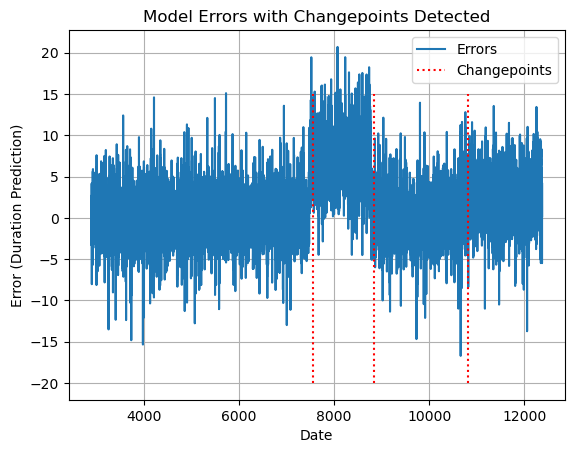

In [ ]:
# Plot errors with changepoints
ax = sns.lineplot(x=errors.index, y=errors, label="Errors")
ax.vlines(x=changes, ymin=-20, ymax=15, colors="red", linestyles="dotted", label="Changepoints")
plt.title("Model Errors with Changepoints Detected")
plt.xlabel("Date")
plt.ylabel("Error (Duration Prediction)")
plt.legend()
plt.grid(True)
plt.show()

According to your appreciation, what would be the confusion matrix for our case (forget about true negatives... so many) ?

|  | Observed | |
|---|---|---|
| **Estimated** | Positive | Negative |
| Positive | 0 | 0 |
| Negative | 0 | - |

In [ ]:
threshold = 10  # Assume errors within 10 units are acceptable

# Compute confusion matrix-like terms
TP = sum(abs(errors) <= threshold)
FP = sum(abs(errors) > threshold)

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")

True Positives (TP): 9148
False Positives (FP): 338


This type of output indicate that there is a good precision for positive predictions.